In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

c:\Users\sande\Desktop\repos\norwai\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda


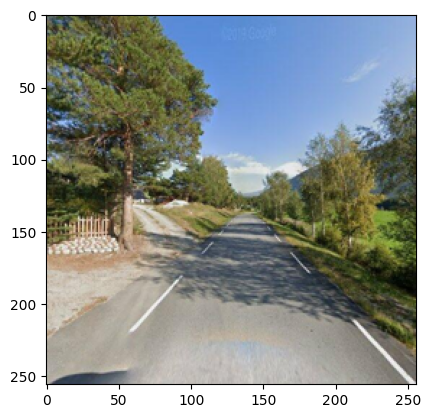

In [4]:
test_images = [{'file':'0001', 'loc':[69.6876088,23.5747422]}]
test_im = np.random.choice(test_images, 1)[0]

from PIL import Image

im = Image.open('./data/test_images/{}.png'.format(test_im['file'])).convert('RGB')
w, h = im.size
left = int((w - 512)/2)
top = int((h - 512)/2)
right = int((w + 512)/2)
bottom = int((h + 512)/2)

im = im.crop((left, top, right, bottom)).resize((256, 256))
im_data = torch.tensor(np.asarray(im).transpose(2, 0, 1))

plt.imshow(im_data.int().numpy().transpose(1, 2, 0))
plt.show()

In [6]:
mean = 135.4867 # fix this
std = 64.0806 # fix this
im_data = im_data.to(device)
im_data = (im_data - mean) / std

model = torch.load('./data/model_classification')
model.to(device)

guessed_county = None
with torch.no_grad():
  y = model(im_data.unsqueeze(0)).flatten()
  
  print(torch.exp(y))
  guessed_county = torch.argmax(torch.exp(y)).item()


AttributeError: Can't get attribute 'NSVDModel' on <module '__main__'>

tensor([-2.7660, -4.7697, -0.9924, -2.6751, -4.7380, -4.6915, -3.9974, -1.0149,
        -3.5734, -3.2383, -3.7712], device='cuda:0')

        tensor([0.0229, 0.0040, 0.1579, 0.0185, 0.0032, 0.0243, 0.0349, 0.4960, 0.0541,
        0.1400, 0.0442], device='cuda:0')

In [ ]:
df = pd.read_json("./data/norge.geojson")
fylker = df["administrative_enheter.fylke"]["features"]

In [ ]:
import folium

real_loc = test_im['loc']
FYLKESNUMMER_INDEX = [42, 3, 54, 15, 38, 50, 11, 34, 30, 18, 46]

fylke = None
for f in fylker:
    if int(f["properties"]["fylkesnummer"]) == FYLKESNUMMER_INDEX[guessed_county]:
        print("found")
        fylke = f
        break


In [ ]:
print(fylke["properties"]["fylkesnummer"])

In [ ]:
gdf = gpd.GeoDataFrame.from_features([fylke])

In [ ]:
print(fylke)

In [ ]:
#gdf = gpd.GeoDataFrame.from_features(fylker)
#sim_geo = gpd.GeoSeries(fylke['geometry']).simplify(tolerance=0.001)
#geo_j = sim_geo.to_json()
gdf = gdf.set_crs(epsg=25833)
gdf = gdf.to_crs(epsg=4326)
geo_j = folium.GeoJson(data=gdf["geometry"][0],
    style_function=lambda x: {'fillColor': 'orange'})


m = folium.Map((64.9701, 13.509217), zoom_start=4)


geo_j.add_to(m)
folium.CircleMarker(location=(real_loc[0], real_loc[1]), tooltip='real', radius=1, color='#0080bb', fill_color='#0080bb').add_to(m)
m